### 0. Import util libraries


In [1]:
import xarray as xr
import numpy as np
from matplotlib import rc

from inversion_sst_gp import (
    plot_helper,
    utils,
    gp_regression,
    particle_tracking,
)

rc("font", family="serif", serif=["Computer Modern"])
rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{amsmath}")

In [2]:
# Plotting parameters
lonlims = (115, 118)
latlims = (-15.5, -12.5)

### 1. Satellite case 2


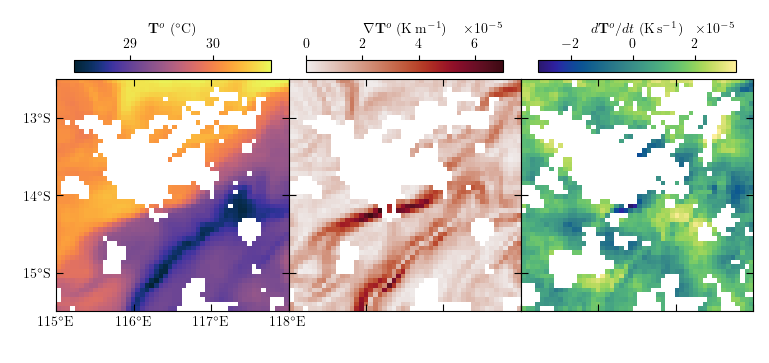

In [3]:
# Load datasets
time_himawari_str = "2023-12-18T01:00:00"
time_altimetry_str = "2023-12-18T00:00:00"

# Load Himawari data
ds = xr.open_dataset("1_preproc_data/proc_data/himawari.nc").sel(
    time=np.datetime64(time_himawari_str)
)
time_step = ds.time_step.item()
lon, lat, To, dTdto = (ds[var].values for var in ("lon", "lat", "T", "dTdt"))
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(
    LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims
)

In [4]:
# Load altimetry current data
ds_altimetry = xr.open_dataset("1_preproc_data/proc_data/altimeter_currents.nc").sel(
    time=time_altimetry_str
)
lonr, latr, ugos, vgos = (
    ds_altimetry[var].values for var in ("lon", "lat", "ugos", "vgos")
)
_, _, _, _, LONr, LATr = utils.calculate_grid_properties(lonr, latr)

In [5]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "2_covariance_parameter_estimation/outputs/satellite_gp_obs_t.csv",
    "time",
    time_himawari_str,
    type="gp",
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel, Kxstar = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step, return_Kxstar=True
    )
)

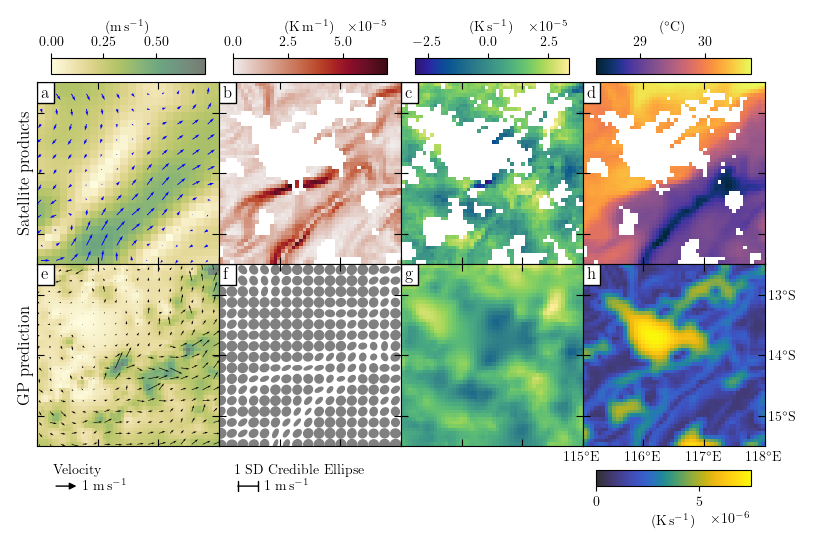

In [6]:
# Plot predictions
fig, ax = plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    LONr=LONr,
    LATr=LATr,
    ur=ugos,
    vr=vgos,
    pscale=7,
    nx=16,
    ny=16,
    nxr=16,
    nyr=16,
    return_fig=True,
)
fig.savefig(
    "4_satellite_application/figures/satellite_case_2_prediction.png",
    bbox_inches="tight",
    dpi=300,
)

#### 2.2. Particle tracking


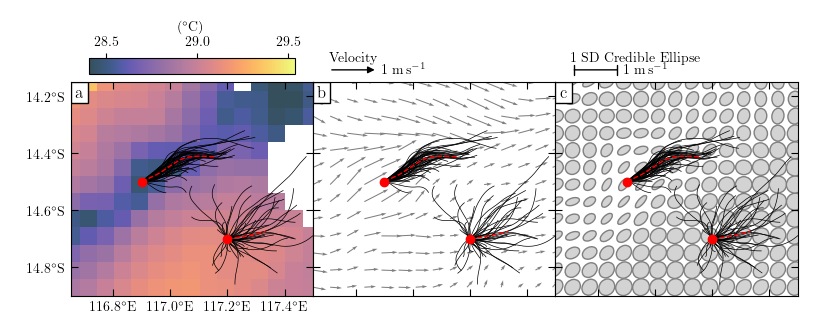

In [7]:
# Simulate velocity fields from prediction
np.random.seed(0)
us, vs = particle_tracking.simulate_flow_fields(
    Kxstar, muustar, muvstar, len(lat), len(lon), 50
)

# Track particles over simulated velocity fields
tstep = 120
Nstep = 24 * 30
release_coords_1 = (116.9, -14.5)
release_coords_2 = (117.2, -14.7)

releases = [(release_coords_1), release_coords_2]
list_dict_tracks = []
for release in releases:
    lon0, lat0 = release
    lons, lats = particle_tracking.simulate_particle_multi_flow_fields(
        X, Y, us, vs, lon0, lat0, lonc, latc, tstep, Nstep
    )
    lonsm, latsm = particle_tracking.simulate_particle_flow_field(
        X, Y, muustar, muvstar, lon0, lat0, lonc, latc, tstep, Nstep
    )
    dict_particle = {
        "lons": lons,
        "lats": lats,
        "lonsm": lonsm,
        "latsm": latsm,
        "lon0": lon0,
        "lat0": lat0,
    }
    list_dict_tracks.append(dict_particle)

# Plot particle tracking
fig, ax = plot_helper.plot_particle_tracking(
    list_dict_tracks,
    lon,
    lat,
    muustar,
    muvstar,
    Kxstar_vel,
    To,
    pscale=5,    
    return_fig=True,
)
fig.savefig(
    "4_satellite_application/figures/satellite_case_2_particle_tracking.png",
    bbox_inches="tight",
    dpi=300,
)